## Import

In [47]:
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

## Pre-Processing

In [26]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [64]:
smiles = [' '.join([i for i in tp[j]]) for j in range(len(train))]

['C C O c 1 c c c ( C N C ( = O ) c 2 c c ( - c 3 s c ( C ) n c 3 C ) n [ n H ] 2 ) c c 1 O C C',
 'C c 1 n c ( C ) c ( C N 2 C C ( C ) C ( = O ) N c 3 c c c c c 3 2 ) s 1',
 'C C C N 1 C C N ( c 2 n n 3 n n n c 3 c 3 c c c c c 2 3 ) C C 1',
 'C c 1 c c c ( - c 2 c c c ( - n 3 n c ( C ) c ( S ( = O ) ( = O ) N 4 C C N ( C 5 C C C C C 5 ) C C 4 ) c 3 C ) n n 2 ) c c 1',
 'C c 1 c c c 2 c ( c 1 ) N ( C ( = O ) c 1 c c n c c 1 ) C C ( C ) O 2',
 'C O c 1 c ( F ) c ( F ) c c 2 c ( = O ) c ( C ( = O ) N C C C N 3 C C C C 3 = O ) c n ( C 3 C C 3 ) c 1 2',
 'C N ( C ) c 1 c c c c 2 c ( S ( = O ) ( = O ) N C ( C C ( = O ) O ) C ( = O ) O ) c c c c 1 2',
 'C 1 = C n 2 n c ( / C = C / c 3 c c c s 3 ) n c 2 - c 2 c c c c c 2 O 1',
 'C O c 1 c c c 2 n c ( C 3 = C C C N ( C ) C 3 ) n ( C ) c 2 c 1',
 'C C N 1 C C C C 1 C N C ( = O ) C 1 C C C N ( c 2 n c n c 3 [ n H ] c n c 2 3 ) C 1',
 'C N ( C 1 C C N C C 1 ) S ( = O ) ( = O ) c 1 c c c ( C l ) s 1',
 'C C 1 C N ( C c 2 c n c s 2 ) C C N 1 C C ( 

In [82]:
tp = [[j for j in i] for i in train['SMILES']]
ans = []
for i in tp:
    ans.extend(i)
    
import collections
data = pd.DataFrame([collections.Counter(ans).keys(),collections.Counter(ans).values()]).transpose()
data.columns = ['atom','counter']
data.sort_values('counter',ascending=False).reset_index(drop=True)

,atom,counter
0,c,39802
1,C,26001
2,(,14796
3,),14796
4,1,10300
5,O,8501
6,2,8238
7,n,6846
8,=,5753
9,N,4798


중괄호안 이온 , +,- 붙일것 Br 붙일것, @와 @@

In [29]:
test

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15
...,...,...,...,...,...,...,...,...,...
478,TEST_478,CCc1noc(CC)c1CC(=O)NCC1(CC)CCCCC1,4.207,306.443,2,1,7,4.207,55.13
479,TEST_479,CC(=O)N1CCC2(CC1)OC(=O)C(C)=C2C(=O)N1CCN(C)CC1,-0.608,335.398,5,0,1,-1.736,70.16
480,TEST_480,CC(C)NC(=O)CN1C(=O)c2ccccc2N2C(=O)c3ccccc3C12,1.792,349.383,3,1,3,1.792,69.72
481,TEST_481,Cn1cc(Br)c(=O)c(NC(=O)c2ccc(O)cc2F)c1,0.790,341.132,3,2,2,0.423,69.64


In [5]:
PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

In [6]:
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [7]:
# FPs column 추가
train["FPs"] = train.Molecule.apply(mol2fp)
test["FPs"] = test.Molecule.apply(mol2fp)

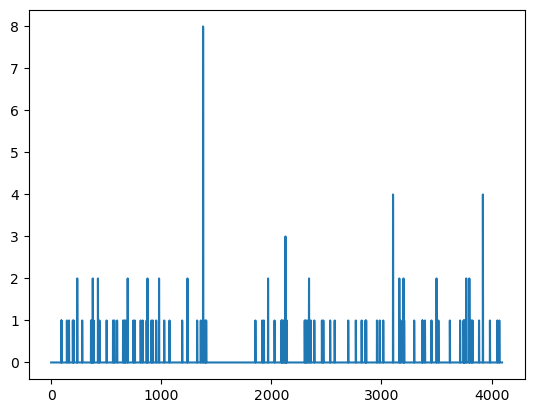

In [8]:
import matplotlib.pyplot as plt
plt.plot(train['FPs'][0])

In [9]:
# 사용할 column만 추출
train = train[['FPs','MLM', 'HLM']]
test = test[['FPs']]

## Custom Dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df, target, transform, is_test=False):
        self.df = df
        self.target = target # HLM or MLM
        self.is_test = is_test # train,valid / test

        self.feature_select = transform
        if not self.is_test: 
            self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))
        else: # valid or test
            self.fp = self.feature_select.transform(np.stack(df['FPs']))

    def __getitem__(self, index):
        fp = self.fp[index]
        if not self.is_test: # test가 아닌 경우(label 존재)
            label = self.df[self.target][index]
            return torch.tensor(fp).float(), torch.tensor(label).float().unsqueeze(dim=-1) # feature, label

        else: # test인 경우
            return torch.tensor(fp).float() # feature
        
    def __len__(self):
        return len(self.df)

In [11]:
transform = VarianceThreshold(threshold=0.05)

train_MLM = CustomDataset(df=train, target='MLM', transform=transform, is_test=False)
train_HLM = CustomDataset(df=train, target='HLM', transform=transform, is_test=False)

input_size = train_MLM.fp.shape[1]
input_size

251

In [12]:
# Hyperparameter
CFG = {'BATCH_SIZE': 256,
       'EPOCHS': 1000,
       'INPUT_SIZE': input_size,
       'HIDDEN_SIZE': 1024,
       'OUTPUT_SIZE': 1,
       'DROPOUT_RATE': 0.8,
       'LEARNING_RATE': 0.001}

In [13]:
# train,valid split
train_MLM_dataset, valid_MLM_dataset = train_test_split(train_MLM, test_size=0.2, random_state=42)
train_HLM_dataset, valid_HLM_dataset = train_test_split(train_HLM, test_size=0.2, random_state=42)

In [14]:
train_MLM_loader = DataLoader(dataset=train_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_MLM_loader = DataLoader(dataset=valid_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)


train_HLM_loader = DataLoader(dataset=train_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_HLM_loader = DataLoader(dataset=valid_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)

## Model

In [15]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        
        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        
        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        
        # 활성화 함수
        self.activation = nn.LeakyReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

In [16]:
model_MLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])
model_HLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])

In [17]:
criterion = nn.MSELoss()
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])

## Training

In [18]:
def train(train_loader, valid_loader, model, criterion, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        if epoch % 100 == 0:
            valid_loss = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = criterion(output, targets)
                    valid_loss += loss.item()
                    
            print(f'Epoch: {epoch}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss/len(valid_HLM_loader)}')
            
            model.train()
    
    return model

In [20]:
print("Training Start: MLM")
model_MLM = train(train_MLM_loader, valid_MLM_loader, model_MLM, criterion, optimizer_MLM, epochs=CFG['EPOCHS'])

print("Training Start: HLM")
model_HLM = train(train_HLM_loader, valid_HLM_loader, model_HLM, criterion, optimizer_HLM, epochs=CFG['EPOCHS'])  

Training Start: MLM
Epoch: 0/1000, Train Loss: 1275.9594060724432, Valid Loss: 1346.3698323567708


KeyboardInterrupt: 

## Inference

In [ ]:
test_MLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)
test_HLM = CustomDataset(df=test, target=None, transform=transform, is_test=True)

test_MLM_loader = DataLoader(dataset=test_MLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

test_HLM_loader = DataLoader(dataset=test_HLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

In [ ]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs in test_loader:
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [ ]:
predictions_MLM = inference(test_MLM_loader, model_MLM)
predictions_HLM = inference(test_HLM_loader, model_HLM)

## Submission

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission

In [ ]:
submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM
submission

In [ ]:
submission.to_csv('baseline_submission.csv', index=False)